In [1]:
import pandas as pd
import numpy as np
from simanneal import Annealer

In [304]:
df = pd.read_csv('family_data.csv')

### Functions

In [5]:
#cost matrix for all choices of all families
def pref_cost(df):
    df_cost=df.copy()
    df_cost['wildcard_choice'] = 0
    for i in range(len(df_cost)):
        n = df_cost.iloc[i,11]  #number of people
        df_cost.iloc[i,1]=0          #ch0
        df_cost.iloc[i,2]=50          #ch1
        df_cost.iloc[i,3]=50+(9*n)          #ch2
        df_cost.iloc[i,4]=100+(9*n)          #ch3
        df_cost.iloc[i,5]=200+(9*n)          #ch4
        df_cost.iloc[i,6]=200+(18*n)          #ch5
        df_cost.iloc[i,7]=300+(18*n)          #ch6
        df_cost.iloc[i,8]=300+(36*n)          #ch7
        df_cost.iloc[i,9]=400+(36*n)          #ch8
        df_cost.iloc[i,10]=500+(36*n)+(199*n)          #ch9
        df_cost.iloc[i,12]=500+(36*n)+(398*n)          #ch10-wildcard
    return df_cost.drop(columns='n_people')

In [236]:
#get accounting penalty cost
def acct_pen(df):
    cost=0
    occu_df = df.groupby('assigned_day')['n_people'].sum().reset_index()
    occu_df = occu_df.sort_values('assigned_day', ascending=False)
    prev_occup=int(occu_df[occu_df.assigned_day==100]['n_people']) #because Nd(100)==Nd(101)
    acct_cost=0
    for index, row in occu_df.iterrows():
        o = row['n_people']
        #print(o, '-', prev_occup)
        power = 0.5 + (abs(o - prev_occup)/50)
        acct_cost += max(0, ((o - 125)/400)*o**power)
        prev_occup = o
    return acct_cost        

In [192]:
#to check if any day is violating occupancy constraint
def day_constraint(df):
    arr = df.groupby('assigned_day')['n_people'].sum().values
    for i in arr:
        if i < 125 or i >300:
            print (f'constraint violated')
            break
    if len(arr)==100:
        print('No Violation')

In [164]:
#get total preference cost for all families based on their assigned days.
def pref_cost_family(cost_df, family_df, output_df):
    tot_pref_cost_val = 0
    for index, row in output_df.iterrows():
        f_id = row['family_id']
        a_day = row['assigned_day']
        f_choices = family_df[family_df.family_id==f_id].drop(columns=['n_people', 'family_id']).values[0]
        ch_id = 0
        for i, e in enumerate(f_choices):   
            if e==a_day:
                ch_id = i + 1
                break
            else:
                ch_id = 11 #wildcard choice
        pref_cost_val = cost_df.iloc[f_id, ch_id]
        tot_pref_cost_val+=pref_cost_val
        #print(f'cost for family {f_id} is {pref_cost_val} because of choice {ch_id} which was day {a_day}')
    return tot_pref_cost_val

In [408]:
#moving families to their lower choices to reduce the cost.
#It will serve as the initial dataset for swapping.

def moving_pref(inp_df,out_df, choice_df):
    df = inp_df
    for index, row in df.iterrows():
        pref_occup=[]
        f_id = row['family_id']
        n=row['n_people']
        current_assigned_day = row['assigned_day']
        occ_day = initial[initial.assigned_day==current_assigned_day]['n_people'].sum()
        prefs = choice_df[choice_df.family_id==f_id].drop(columns=['family_id', 'n_people']).values[0]
        for i, e in enumerate(prefs):
            pref_occup.append(out_df[out_df.assigned_day==e]['n_people'].sum())
        for i, e in enumerate(pref_occup):
            if e+n>125 and e+n<250 and occ_day-n>=125:
                new_assigned_day = prefs[i]
                prev_day = new_assigned_day - 1
                occupany_that_day = initial[initial.assigned_day==new_assigned_day]['n_people'].sum()
                occupany_prev_day = initial[initial.assigned_day==prev_day]['n_people'].sum()
                delta = abs(occupany_that_day - occupany_prev_day)
                if delta > 50:
                    break
                else:
                    out_df.loc[out_df.family_id==f_id, 'assigned_day']=new_assigned_day
                    out_df.loc[out_df.family_id==f_id, 'choice_id']=i
                    break
    return out_df

### Creating initial dataset from sample submission

In [157]:
sample = pd.read_csv('sample_submission.csv')

In [158]:
sample_sub = pd.merge(sample, df[['family_id','n_people']], on='family_id', how='inner')

In [250]:
cost = pref_cost(df)

In [161]:
choice_array=[]
cost_array=[]

for index, row in sample_sub.iterrows():
        f_id = row['family_id']
        a_day = row['assigned_day']
        f_choices = df[df.family_id==f_id].drop(columns=['n_people', 'family_id']).values[0]
        ch_id = 0
        for i, e in enumerate(f_choices):   
            if e==a_day:
                ch_id = i + 1
                break
            else:
                ch_id = 11 #wildcard choice
        pref_cost_val = cost.iloc[f_id, ch_id]
        choice_array.append(ch_id)
        cost_array.append(pref_cost_val)

sample_sub['choice_id']=ch_ar
sample_sub['pref_cost_val']=cost_ar

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1159d3e48>]],
      dtype=object)

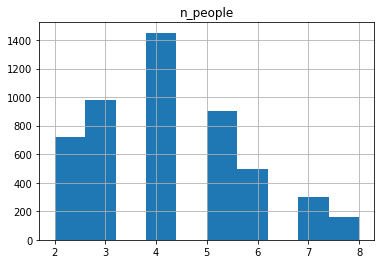

In [155]:
df[['n_people']].hist()

 Higher number of people in the family, higher cost to move them

There should be "moving weight" based on the size of the family

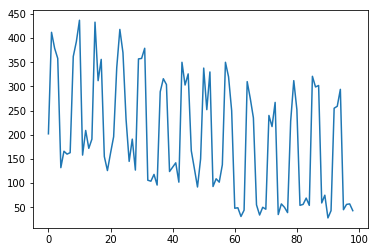

In [19]:
df[df.choice_0!=1][['family_id','choice_0', 'n_people']].groupby('choice_0')['n_people'].sum().reset_index()['n_people'].plot()

**First step is to take a "top down" approach i-e select days where there is most violation and come up with a first solution which will then be iterated using swapping or some other algorithm**

Ideal is to take all customers's 0th priority and swap guys on days where constraint is violated.
Which customers to be moved will be defined by how easy it is move a family
- Number of people in the family
- Next available priority of the family is in the days which are "green"


In [18]:
#checking for each choice how many violations
cols=df.drop(columns=['family_id','n_people'])
for col in cols:
    val=[]
    arr = df.groupby(col)['n_people'].sum().reset_index()['n_people'].values
    c=0
    for i, e in enumerate(arr):
        if e < 125 or e > 300:
            c+=1
            val.append(e)
    print(f'for {col} there are {c} days which violate the constraint with mean {np.mean(val)}')

for choice_0 there are 63 days which violate the constraint with mean 216.57142857142858
for choice_1 there are 59 days which violate the constraint with mean 217.6271186440678
for choice_2 there are 68 days which violate the constraint with mean 210.2941176470588
for choice_3 there are 64 days which violate the constraint with mean 205.625
for choice_4 there are 66 days which violate the constraint with mean 213.07575757575756
for choice_5 there are 63 days which violate the constraint with mean 204.0793650793651
for choice_6 there are 63 days which violate the constraint with mean 212.34920634920636
for choice_7 there are 63 days which violate the constraint with mean 212.47619047619048
for choice_8 there are 63 days which violate the constraint with mean 210.76190476190476
for choice_9 there are 62 days which violate the constraint with mean 214.91935483870967


### Start Moving

for a family with max cost
    Check the first prio
        if number of people within constraint, move the family to that prio
        else prio+1

create group of families with choice 11 ranked on cost
Move them one group at a time starting from top ranked group

In [ ]:
Days cant be too crowded as it significantly increases accounting penalty.
one way which i have done above is to change the occupancy violation range

In [409]:
initial = sample_sub[['family_id','assigned_day','pref_cost_val', 'choice_id', 'n_people']]
initial = initial.rename(columns={'assigned_day':'initial_assigned_day', 'pref_cost_val':'initial_cost', 'choice_id':'initial_choice_id'})
initial['assigned_day']=initial['initial_assigned_day']
initial['choice_id']=initial['initial_choice_id']

In [410]:
rank = [3972,3538,3104,2670,2236,1802,1368]
for i,e in enumerate(rank):
    sample_sub_ss = sample_sub[(sample_sub.pref_cost_val==e)&(sample_sub.choice_id==11)]
    initial = moving_pref(sample_sub_ss, initial, df)
    x=acct_pen(initial)
    y=pref_cost_family(cost, df, initial)
    print(x,'-',y)

9906.097899257828 - 10167173
90771.41844338 - 9372799
625611.7761668903 - 8337923
6014962.666119003 - 7173773
12705445.913703056 - 6168511
21785633.1622485 - 5748486
28134143.960302263 - 5540912


In [416]:
#families moved
initial[initial.initial_assigned_day!=initial.assigned_day]['family_id'].count()

1981

### Removing Congestion

Some days are more congested then the rest, as a result accounting cost is very high
Idea is to remove this congestion by swapping families.

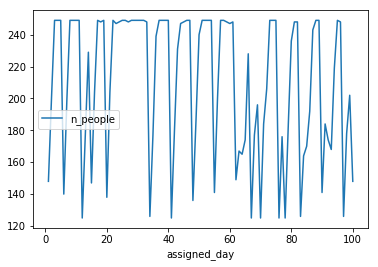

In [411]:
occu_df = initial.groupby('assigned_day')['n_people'].sum().reset_index()
occu_df.plot(x='assigned_day', y='n_people')

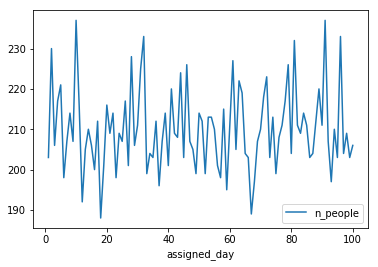

In [405]:
ss = sample_sub.groupby('assigned_day')['n_people'].sum().reset_index()
ss.plot(x='assigned_day', y='n_people')

In [407]:
acct_pen(sample_sub)

1907.4031350226594

In [417]:
initial.groupby('choice_id')['family_id'].count()

choice_id
0     1229
1      466
2      228
3      124
4       96
5       60
6       54
7       53
8       42
9       75
10      52
11    2521
Name: family_id, dtype: int64

### Check Constraint and Calculate Cost 

In [412]:
x=acct_pen(initial)
x

28134143.960302263

In [413]:
day_constraint(initial)

No Violation


In [414]:
val=pref_cost_family(cost, df, initial)
val

5540912

In [415]:
total_cost=val+x
total_cost

33675055.96030226

### Prepare Submission File

In [375]:
submission = initial[['family_id','assigned_day']]
submission.to_csv('submit.csv', index=False)

In [377]:
sample.columns

Index(['family_id', 'assigned_day'], dtype='object')

In [211]:
family_size_dict = df[['n_people']].to_dict()['n_people']

cols = [f'choice_{i}' for i in range(10)]
choice_dict = df[cols].to_dict()

N_DAYS = 100
MAX_OCCUPANCY = 300
MIN_OCCUPANCY = 125

# from 100 to 1
days = list(range(N_DAYS,0,-1))

In [224]:
def cost_function(prediction):

    penalty = 0

    # We'll use this to count the number of people scheduled each day
    daily_occupancy = {k:0 for k in days}
    
    # Looping over each family; d is the day for each family f
    for f, d in enumerate(prediction):

        # Using our lookup dictionaries to make simpler variable names
        n = family_size_dict[f]
        choice_0 = choice_dict['choice_0'][f]
        choice_1 = choice_dict['choice_1'][f]
        choice_2 = choice_dict['choice_2'][f]
        choice_3 = choice_dict['choice_3'][f]
        choice_4 = choice_dict['choice_4'][f]
        choice_5 = choice_dict['choice_5'][f]
        choice_6 = choice_dict['choice_6'][f]
        choice_7 = choice_dict['choice_7'][f]
        choice_8 = choice_dict['choice_8'][f]
        choice_9 = choice_dict['choice_9'][f]

        # add the family member count to the daily occupancy
        daily_occupancy[d] += n

        # Calculate the penalty for not getting top preference
        if d == choice_0:
            penalty += 0
        elif d == choice_1:
            penalty += 50
        elif d == choice_2:
            penalty += 50 + 9 * n
        elif d == choice_3:
            penalty += 100 + 9 * n
        elif d == choice_4:
            penalty += 200 + 9 * n
        elif d == choice_5:
            penalty += 200 + 18 * n
        elif d == choice_6:
            penalty += 300 + 18 * n
        elif d == choice_7:
            penalty += 300 + 36 * n
        elif d == choice_8:
            penalty += 400 + 36 * n
        elif d == choice_9:
            penalty += 500 + 36 * n + 199 * n
        else:
            penalty += 500 + 36 * n + 398 * n

    # for each date, check total occupancy
    #  (using soft constraints instead of hard constraints)
    for _, v in daily_occupancy.items():
        if (v > MAX_OCCUPANCY) or (v < MIN_OCCUPANCY):
            print('fucked')
            penalty += 100000000

    # Calculate the accounting cost
    # The first day (day 100) is treated special
    accounting_cost = (daily_occupancy[days[0]]-125.0) / 400.0 * daily_occupancy[days[0]]**(0.5)
    # using the max function because the soft constraints might allow occupancy to dip below 125
    accounting_cost = max(0, accounting_cost)
    
    # Loop over the rest of the days, keeping track of previous count
    yesterday_count = daily_occupancy[days[0]]
    for day in days[1:]:
        today_count = daily_occupancy[day]
        diff = abs(today_count - yesterday_count)
        accounting_cost += max(0, (daily_occupancy[day]-125.0) / 400.0 * daily_occupancy[day]**(0.5 + diff / 50.0))
        yesterday_count = today_count

    print(f'pref cost: {penalty}')
    print(f'acct cost: {accounting_cost}')
    penalty += accounting_cost

    return penalty

In [225]:
l = submission['assigned_day'].tolist()

In [226]:
cost_function(l)

pref cost: 10087683
acct cost: 760501.4878629199


10848184.48786292

In [235]:
cost=0
occu_df = initial.groupby('assigned_day')['n_people'].sum().reset_index()
occu_df = occu_df.sort_values('assigned_day', ascending=False)
prev_occup=int(occu_df[occu_df.assigned_day==100]['n_people']) #because Nd(100)==Nd(101)
acct_cost=0
for index, row in occu_df.iterrows():
    o = row['n_people']
    power = 0.5 + (abs(o - prev_occup)/50)
    acct_cost += max(0, ((o - 125)/400)*o**power)
    prev_occup = o
acct_cost

760501.4878629199

In [233]:
occu_df = occu_df.sort_values('assigned_day', ascending=False)
occu_df

,assigned_day,n_people
99,100,206
98,99,203
97,98,201
96,97,212
95,96,249
94,95,203
93,94,210
92,93,197
91,92,199
90,91,213
